In [1]:
from netCDF4 import Dataset

import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import geopandas as gp
import xarray as xr
import rioxarray as rxr
from rasterio.plot import plotting_extent
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep
import numpy as np 

In [33]:
testpath = '/home/tom/Documents/UC/Project/data/dap.ceda.ac.uk/neodc/esacci/fire/data/burned_area/MODIS/grid/v5.1/2004'
testfile = '20040301-ESACCI-L4_FIRE-BA-MODIS-fv5.1.nc'

rootgrp = Dataset(testpath + '/' + testfile, "r", format="NETCDF4")

print(rootgrp)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    title: Fire_cci Gridded MODIS Burned Area product
    institution: University of Alcala
    source: MODIS MOD09GQ Collection 6, MODIS MOD09GA Collection 6, MODIS MCD14ML Collection 6, ESA CCI Land Cover dataset v2.0.7
    history: Created on 2018-12-01 03:23:27
    references: See www.esa-fire-cci.org
    tracking_id: e06b5b77-6829-4731-a034-bcc8f991c5f6
    Conventions: CF-1.6
    product_version: v5.1
    summary: The grid product is the result of summing up burned area pixels and their attributes, as extracted from their original sinusoidal projection, within each cell of 0.25 degrees in a regular grid covering the whole Earth in monthly composites. The attributes stored are sum of burned area, standard error, fraction of burnable area, fraction of observed area, number of patches and the burned area for 18 land cover classes of Land Cover CCI.
    keywords: Burned Area, Fire Disturb

In [9]:
def lat_to_idx(latitude):
    return (90 - latitude)*4

def lon_to_idx(longitude):
    return (-180 - longitude)*-4

In [35]:
var_name = 'lat_bnds'
var = rootgrp.variables[var_name]

sth_kor_lat_min = 32
sth_kor_lat_max = 39
sth_kor_lon_min = 125
sth_kor_lon_max = 130
print
var = rootgrp.variables[var_name]

#print(np.asarray(var))
#print(var[lon_to_idx(sth_kor_lon_min):lon_to_idx(sth_kor_lon_max)])

var_name = 'burned_area'
var = rootgrp.variables[var_name]

print(np.array(var[:, lat_to_idx(sth_kor_lat_max):lat_to_idx(sth_kor_lat_min), lon_to_idx(sth_kor_lon_min):lon_to_idx(sth_kor_lon_max)]))
print(np.array(var[:, lat_to_idx(sth_kor_lat_max):lat_to_idx(sth_kor_lat_min), lon_to_idx(sth_kor_lon_min):lon_to_idx(sth_kor_lon_max)]).shape)

[[[       0.        0.        0.        0.        0.        0.        0.
          0.        0.        0. 26832334. 30105878.        0.        0.
          0.        0.        0.        0.        0.        0.]
  [       0.        0.        0.        0.        0.        0.        0.
          0.        0.  3971185.        0.        0.  2468574.  1019628.
          0.        0.        0.        0.        0.        0.]
  [       0.        0.        0.        0.        0.        0.        0.
     375652. 36116320.   536646.  7298394.   268323.  6869077.        0.
          0.        0.        0.        0.        0.        0.]
  [       0.        0.        0.        0.        0.        0.        0.
    5098143. 12020885.        0.        0.        0.        0.        0.
          0.        0.        0.        0.        0.        0.]
  [       0.        0.        0.        0.        0.        0.        0.
          0.        0.        0.        0.        0.        0.        0.
          0.  

In [10]:
with rio.open("20140201-ESACCI-L3S_FIRE-BA-MODIS-AREA_4-fv5.1-CL.tif") as dataset:
    # Read the dataset's valid data mask as a ndarray.
    mask = dataset.dataset_mask()

    # Extract feature shapes and values from the array.
    for geom, val in rio.features.shapes(
            mask, transform=dataset.transform):

        # Transform shapes from the dataset's own coordinate
        # reference system to CRS84 (EPSG:4326).
        geom = rio.warp.transform_geom(
            dataset.crs, 'EPSG:4326', geom, precision=6)

        
        # Print GeoJSON shapes to stdout.
        print(geom)
geom.plot()

{'type': 'Polygon', 'coordinates': [[[52.999301, 83.00005], [52.999301, -0.0], [180.0, -0.0], [180.0, 83.00005], [52.999301, 83.00005]]]}


AttributeError: 'dict' object has no attribute 'plot'

In [17]:
geometry = gp.GeoDataFrame(geom)


parsed_data = [[item['properties']['raster_val'],
                Polygon(item['geometry']['coordinates'][0])] for item in data]

print(geometry)
geometry.set_geometry('coordinates')
geometry.plot()

      type                                        coordinates
0  Polygon  [[52.999301, 83.00005], [52.999301, -0.0], [18...


TypeError: Input must be valid geometry objects: [[52.999301, 83.00005], [52.999301, -0.0], [180.0, -0.0], [180.0, 83.00005], [52.999301, 83.00005]]

In [22]:
def pixel_lon_to_idx(longitude):
    if longitude < 52.999301 or  longitude > 180:
        return ValueError
    return (longitude - 52.999301) * 445.28888903

def pixel_lat_to_idx(latitude):
    if latitude < 0 or  latitude > 83.00005:
        return ValueError
    return (latitude) * 445.28888903

print(pixel_lon_to_idx(180))

56552.00016374343


## Data collection

In [4]:
# Function to clip the TIFF file
def clip_tiff(file_path, lon_min, lon_max, lat_min, lat_max):
    data = rxr.open_rasterio(file_path)
    clipped_data = data.rio.clip_box(minx=lon_min, miny=lat_min, maxx=lon_max, maxy=lat_max)
    return clipped_data

### Define the bounding box

In [6]:
south_korea_lat_min = 32
south_korea_lat_max = 39
south_korea_lon_min = 125
south_korea_lon_max = 130

### Aggregate data files

In [7]:
# Base directory containing the folders
base_dir = '/home/tom/Documents/UC/Pixel data'

# Dataset to store the clipped data
dataset = []
counter = 0
# Loop through each year directory
for year in os.listdir(base_dir):
    year_dir = os.path.join(base_dir, year)

    # Loop through each subdirectory in the year directory
    for root, dirs, files in os.walk(year_dir):
        for file in files:
            if file.endswith("-CL.tif"):
                file_path = os.path.join(root, file)

                # Extract the 'month' from the directory name if necessary
                month = os.path.basename(root)  # or any other logic to determine the month from the folder name

                # Clip the data and add to the dataset
                clipped_data = clip_tiff(file_path, south_korea_lon_min, south_korea_lon_max, south_korea_lat_min, south_korea_lat_max)
                clipped_data = clipped_data.squeeze() # Remove the band data
                clipped_data = clipped_data.assign_coords({"month": counter})
                clipper_data = clipped_data.expand_dims(dim = "month")
                dataset.append(clipped_data)
                counter += 1

dataset

[<xarray.DataArray (y: 3118, x: 2227)>
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
 Coordinates:
     band         int64 1
   * x            (x) float64 125.0 125.0 125.0 125.0 ... 130.0 130.0 130.0 130.0
   * y            (y) float64 39.0 39.0 39.0 38.99 ... 32.01 32.01 32.0 32.0
     spatial_ref  int64 0
     month        int64 0
 Attributes:
     AREA_OR_POINT:           Area
     TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
     TIFFTAG_XRESOLUTION:     1
     TIFFTAG_YRESOLUTION:     1
     scale_factor:            1.0
     add_offset:              0.0,
 <xarray.DataArray (y: 3118, x: 2227)>
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint

In [10]:
# Concatenate all DataArrays in the dataset list along the 'month' dimension
combined_data = xr.concat(dataset, dim="month")

combined_data.rio.to_raster("combined-CL.tif")

In [12]:
combined_data.shape

(240, 3118, 2227)

In [31]:
combined_data[0][2000][0]

<xarray.DataArray ()>
array(0, dtype=uint8)
Coordinates:
    band         int64 1
    x            float64 125.0
    y            float64 34.51
    spatial_ref  int64 0
    month        int64 0
Attributes:
    AREA_OR_POINT:           Area
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1
    scale_factor:            1.0
    add_offset:              0.0

## Data visualisation

In [2]:
import matplotlib.animation as animation
import matplotlib.colorbar as colorbar

In [1]:
fig, ax = plt.subplots()
test = ax.imshow(combined_data[0])

ax2, _ = colorbar.make_axes(plt.gca())
cbar = colorbar.ColorbarBase(ax2)
#cbar.set_clim(0, 100)

plt.show()

NameError: name 'plt' is not defined

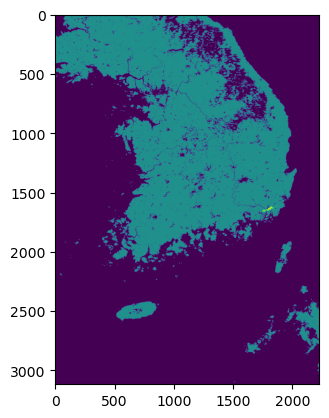

In [5]:
fig, ax = plt.subplots()

def animate(i):
    ax.imshow(combined_data[i])

ani = animation.FuncAnimation(fig, animate, repeat=True, frames=240, interval = 50)


#plt.show()

In [38]:
# To save the animation using Pillow as a gif
writer = animation.PillowWriter()
ani.save('scatter.gif', writer=writer)

KeyboardInterrupt: 

## 

In [3]:
combined_data = rxr.open_rasterio('combined-CL.tif')
combined_data

<xarray.DataArray (band: 240, y: 3118, x: 2227)>
[1666508640 values with dtype=uint8]
Coordinates:
  * band         (band) int64 1 2 3 4 5 6 7 8 ... 234 235 236 237 238 239 240
  * x            (x) float64 125.0 125.0 125.0 125.0 ... 130.0 130.0 130.0 130.0
  * y            (y) float64 39.0 39.0 39.0 38.99 ... 32.01 32.01 32.0 32.0
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:           Area
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1
    scale_factor:            1.0
    add_offset:              0.0

In [4]:
for i, data in enumerate(combined_data):
    temp = np.where(data > 50, 1, 0)
    temp2 = np.where(data > 0, 1, 0)
    new_data = np.zeros(shape=data.shape) + temp + temp2
    combined_data[i] = new_data
#np.unique(combined_data)
#combined_data

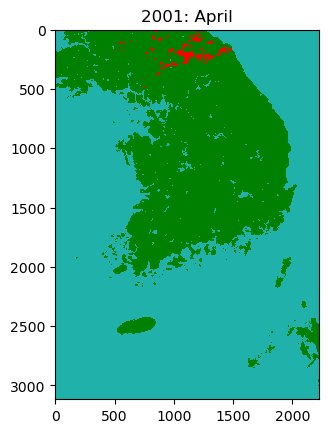

In [23]:
month_dict = {
    0 : 'January',
    1 : 'February',
    2:  'March',
    3: 'April',
    4: 'May',
    5: 'June',
    6: 'July',
    7: 'August',
    8: 'September',
    9: 'October',
    10: 'November',
    11: ' December'
}

n = 3
#cmap = {0: 'lightseagreen', 1: 'gold', 2: 'darkorange'}
cmap = mpl.colors.ListedColormap(["lightseagreen", "green", "red"])
fig, ax = plt.subplots()
test = ax.imshow(combined_data[n], cmap=cmap, vmin=0, vmax=2)
ax.set_title(f'{2001 + (n // 12)}: {month_dict[n % 12]}')
#print(np.unique(combined_data[n]))
#ax2, _ = colorbar.make_axes(plt.gca())
#cbar = colorbar.ColorbarBase(ax2)
#cbar.set_clim(0, 100)

plt.show()

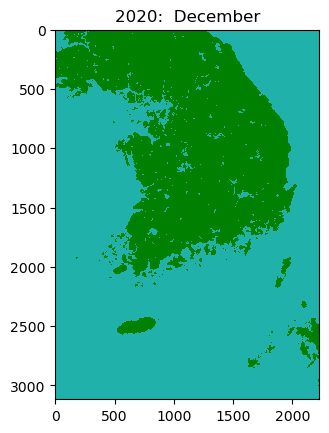

In [25]:
fig, ax = plt.subplots()

def animate(i):
    ax.clear()
    object = ax.imshow(combined_data[i], cmap=cmap, vmin=0, vmax=2)
    ax.set_title(f'{2001 + (i // 12)}: {month_dict[i % 12]}')
    return [object]

ani = animation.FuncAnimation(fig, animate, repeat=False, blit=True, frames=240, interval=400)
# To save the animation using Pillow as a gif

ani.save('scatter.gif', writer=animation.PillowWriter(fps=1))

KeyboardInterrupt: 

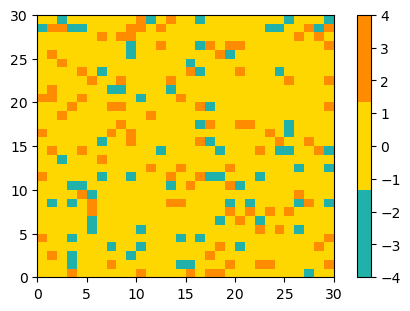

In [29]:
def plot_examples(colormaps):
    """
    Helper function to plot data with associated colormap.
    """
    np.random.seed(19680801)
    data = np.random.randn(30, 30)
    n = len(colormaps)
    fig, axs = plt.subplots(1, n, figsize=(n * 2 + 2, 3),
                            layout='constrained', squeeze=False)
    for [ax, cmap] in zip(axs.flat, colormaps):
        psm = ax.pcolormesh(data, cmap=cmap, rasterized=True, vmin=-4, vmax=4)
        fig.colorbar(psm, ax=ax)
    plt.show()

cmap = mpl.colors.ListedColormap(["lightseagreen", "gold", "darkorange"])
#viridis = mpl.colormaps['viridis']
#print(viridis)
plot_examples([cmap])